# Plotting large datasets


```{dropdown} Required packages
~~~
pip install jupysql memory_profiler
~~~
```

```{tip}
Try this locally:

~~~
pip install k2s -U && k2s get ploomber/jupysql/master/examples/plot.ipynb
~~~

```


*New in version 0.4.4*

```{note}
This is a beta feature, please [join our community](https://ploomber.io/community) and let us know what plots we should add next!
```

Using libraries like `matplotlib` or `seaborn`, requires fetching all the data locally, which quickly can fill up the memory in your machine. JupySQL runs computations in the warehouse/database to drastically reduce memory usage and runtime.

As an example, we are using a sales database from a record store. We’ll find the artists that have produced the largest number of Rock and Metal songs.

Let’s load some data:

In [1]:
import urllib.request
from pathlib import Path
from sqlite3 import connect

if not Path('my.db').is_file():
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite"
    urllib.request.urlretrieve(url, 'my.db')

Now, let's initialize the extension so we only retrieve a few rows.

In [2]:
%load_ext autoreload
%autoreload 2

%load_ext sql
%load_ext memory_profiler

We'll use `sqlite_scanner` extension to load a sample SQLite database into DuckDB:

In [3]:
%%sql duckdb:///
INSTALL 'sqlite_scanner';
LOAD 'sqlite_scanner';
CALL sqlite_attach('my.db');

Done.
Done.
Done.


Success


We'll be using a sample dataset that contains information on music tracks:

In [4]:
%%sql
SELECT * FROM "Track" LIMIT 3

 * duckdb:///
Done.


TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman",230619,3990994,0.99


The `Track` table contains 3503 rows:

In [5]:
%%sql
SELECT COUNT(*) FROM "Track"

 * duckdb:///
Done.


count_star()
3503


Since we want to test plotting capabilities with a large database, we are going to create a new table by appending the original databse multiple times.

For this, we will proceed to create a SQL template script that we will use  along Python to create a database generator. The SQL template will perform a union between the database with itself less or equal than 500 times, because the [maximum number of terms in a compound SELECT statement is **500**](https://www.sqlite.org/limits.html). For our practical case, we will perform this union 5 times.

With this, we will generate a table with ~17.5k rows, as we will see below.

> We invite you to try with a higher number, **why not 450?** <br>
> Just modify the range value from 5 to 450 in the next cell.

In [6]:
%%writefile large-table-template.sql
DROP TABLE IF EXISTS "TrackAll";

CREATE TABLE "TrackAll" AS
    {% for _ in range(5) %}
        SELECT * FROM "Track"
        {% if not loop.last %}
        UNION ALL
        {% endif %}
    {% endfor %}
;

Writing large-table-template.sql


Now, the following Python script will use the SQL template script to generate a now script to create a big table from the database.

In [7]:
%%writefile large-table-gen.py
from pathlib import Path
from jinja2 import Template

t = Template(Path('large-table-template.sql').read_text())
Path('large-table.sql').write_text(t.render())

Writing large-table-gen.py


We can now proceed to execute the Python generator. The Python script can be run using the magic command `%run <file.py>`. After it generates the SQL script, we execute it to create the new table. To execute the SQL script, we use the `--file` flag from from [JupySQL's options](https://jupysql.readthedocs.io/en/latest/options.html) along the `%sql` magic command.

In [8]:
%run large-table-gen.py
%sql --file large-table.sql

 * duckdb:///
Done.
Done.


Count
17515


As we can see, the new table contains **~17.5k rows**.

## Boxplot

```{note}
To use `plot.boxplot`, your SQL engine must support:

`percentile_disc(...) WITHIN GROUP (ORDER BY ...)`

[Snowflake](https://docs.snowflake.com/en/sql-reference/functions/percentile_disc.html),
[Postgres](https://www.postgresql.org/docs/9.4/functions-aggregate.html),
[DuckDB](https://duckdb.org/docs/sql/aggregates), and others support this.
```

In [9]:
from sql import plot
import matplotlib.pyplot as plt
plt.style.use('seaborn')

peak memory: 167.27 MiB, increment: 3.16 MiB


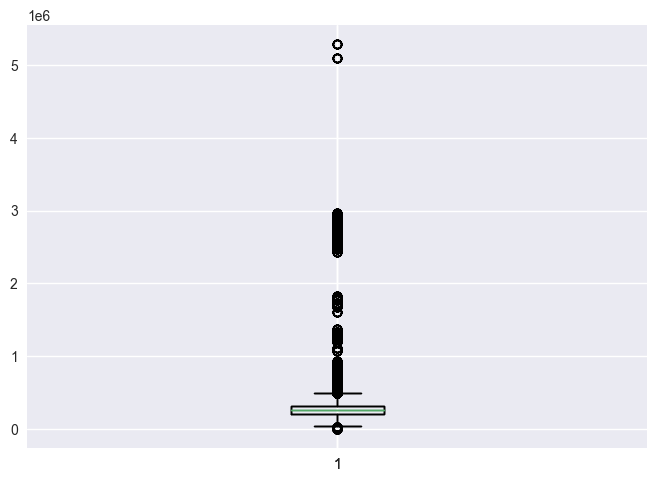

In [10]:
%%memit
plot.boxplot('TrackAll', 'Milliseconds')

Note that the plot consumes only a few MiB of memory (increment), since most of the processing happens in the SQL engine. Furthermore, you'll also see big performance improvements if using a warehouse like Snowflake, Redshift or BigQuery, since they can process large amounts of data efficiently.

## Histogram

peak memory: 174.28 MiB, increment: 0.88 MiB


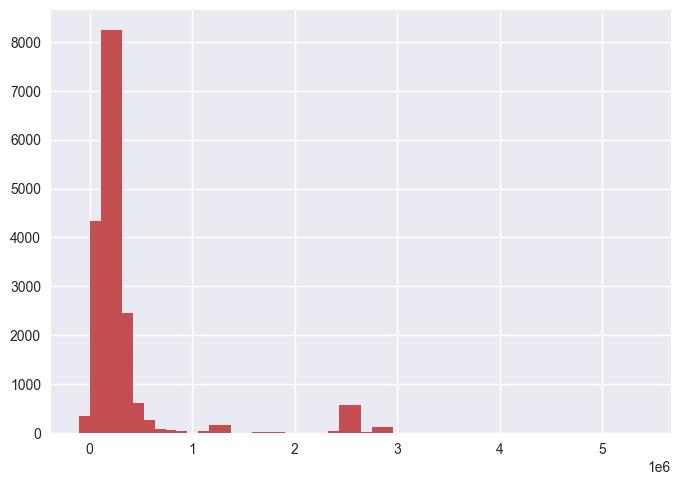

In [11]:
%%memit
plot.histogram('TrackAll', 'Milliseconds', bins=50)

## Benchmark

For comparison, let's see what happens if we compute locally:

In [12]:
from IPython import get_ipython

def fetch_data():
    """
    Only needed to enable %%memit, this is the same as doing
    res = %sql SELECT "Milliseconds" FROM "TrackAll"
    """
    ip = get_ipython()
    return ip.run_line_magic('sql', 'SELECT "Milliseconds" FROM "TrackAll"')

Fetching data consumes a lot of memory:

In [13]:
%%memit
res = fetch_data()

 * duckdb:///
Done.
 * duckdb:///
Done.
 * duckdb:///
Done.
peak memory: 183.20 MiB, increment: 5.05 MiB


Plotting functions also increase memory usage:

peak memory: 176.64 MiB, increment: 2.86 MiB


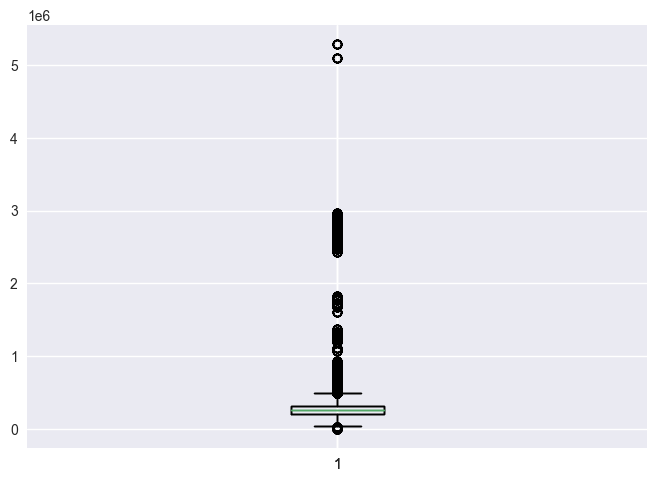

In [14]:
%%memit
_ = plt.boxplot(res.DataFrame().Milliseconds)

peak memory: 183.03 MiB, increment: 1.56 MiB


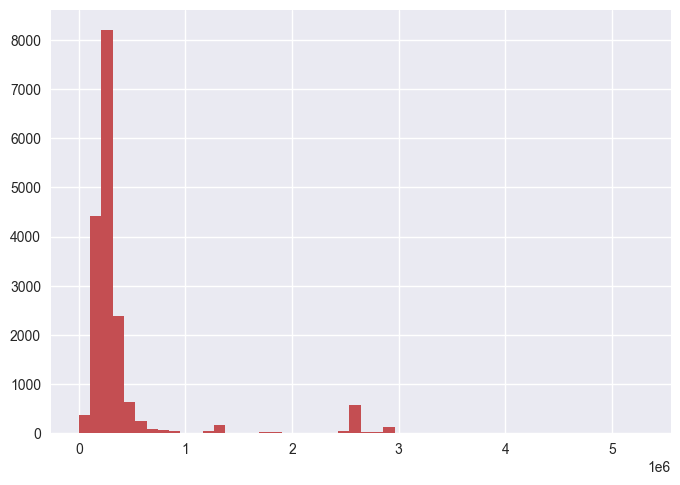

In [15]:
%%memit
_ = plt.hist(res.DataFrame().Milliseconds, bins=50)

The memory consumption is a lot higher!